## S Transformation 

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
img=cv2.imread("./Images/Female.tiff",0)

### Forward transformation 

In [9]:
# img shape 
row=img.shape[0]
col=img.shape[1]
# for saving result after row transformation
row_mat=np.zeros([row,col],dtype=np.int32)
# for saving result after column transformation
col_mat=np.zeros([row,col],dtype=np.int32)
# how far iteration will go 
end=row//2

# Iteration for a single row 
i=0
while i<row:    
    for j in range(end):
        # average formula 
        b=np.floor((int (img[i,2*j])+int (img[i,(2*j)+1]))/2)
        row_mat[i,j]=b
        # detail formula 
        d=int(img[i,2*j])-int(img[i,(2*j)+1])
        row_mat[i,j+int(row/2)]=d
    
    i+=1
# re-intialize for starting iteration on column
i=0
while i<row:
#     print(i)
    for j in range(end):
        # average formula used on column wise 
        b=np.floor((int(row_mat[2*j,i])+int(row_mat[((2*j)+1),i]))/2)
#         print(row_mat[2*j,i]+row_mat[((2*j)+1),i])
        col_mat[j,i]=b
        d=int(row_mat[2*j,i])-int(row_mat[(2*j)+1,i])
        col_mat[j+int(row/2),i]=d
    i+=1


### Result of forward Transformation

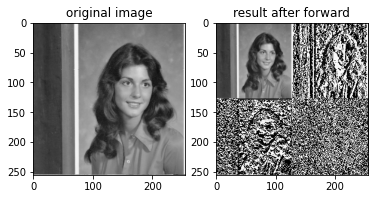

In [10]:
f,axis=plt.subplots(1,2)
after_forward=np.uint8(col_mat)
after_forward1=cv2.cvtColor(after_forward,cv2.COLOR_BGR2RGB)
or_image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
axis[0].title.set_text("original image")
axis[0].imshow(or_image)
axis[1].title.set_text("result after forward")
axis[1].imshow(after_forward1)

### Hiding part

In [11]:
# after forward transformation result was col_mat we take the hh part 
hh=col_mat[row//2:,col//2:]

In [12]:
# load watermark
mark=cv2.imread("./Images/baboon.tiff",0)
mark_resize=cv2.resize(mark,(32,32))

In [13]:
binary_mat=[]
# binary of water mark
for i in range(mark_resize.shape[0]):
    for j in range(mark_resize.shape[1]):
        a=format(abs(mark_resize[i,j]),"08b")
        binary_mat.append(a)

In [14]:
# putting them into one string
steam=""
binary_mat
for i in binary_mat:
    steam+=i

In [15]:
# for modifying the LSB with this binary bits
def modifyBit( n,  p,  b):
    mask = 1 << p
    return (n & ~mask) | ((b << p) & mask)


In [16]:
# copying c matrix for appending binary
temp=hh.copy()
k=0
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        if(k < 8192):
            if(int(hh[i,j])<0):
                #if - then taking absolute value and then adding -
                t=modifyBit(abs(int(hh[i,j])),0,int(steam[k]))
#                 print(t)
                k+=1
                t1=modifyBit(t,1,int(steam[k]))
#                 print("t1",-t1)
                temp[i,j]=(-t1)
#                 print('h',temp[0,0])
                k+=1
            else:
                t=modifyBit(abs(int(hh[i,j])),0,int(steam[k]))
                k+=1
                t1=modifyBit(t,1,int(steam[k]))
                temp[i,j]=t1  
                k+=1
               

In [17]:
# to check matrix has changed or not 
ms=mse(temp,hh)
ms

0.535888671875

In [18]:
# first we have to add this updated part to image
stego_imge=col_mat.copy()
stego_imge[row//2:,col//2:]=temp

In [19]:
# updated image after conversion
stego_imge

array([[  48,   55,   54, ...,    0,    0,   13],
       [  55,   62,   63, ...,   -6,  -25,   13],
       [  55,   63,   63, ...,   -8,  -42,   12],
       ...,
       [  -3,   -2,  -12, ...,    1,    1,    0],
       [  -1,   -1,    0, ...,   -3,   -1,   -1],
       [ -90, -106, -117, ...,   -8,  -63,   -3]], dtype=int32)

In [20]:
# first step of inversion
stego_result=np.zeros([stego_imge.shape[0],stego_imge.shape[1]],dtype=np.int32)
i=0
while i<stego_imge.shape[0]:
    for j in range(end):
        d=stego_imge[j,i]+np.floor((stego_imge[j+int(stego_imge.shape[0]/2),i]+1)/2)
        stego_result[2*j,i]=d
        c=d-stego_imge[j+int(stego_imge.shape[0]/2),i]
        stego_result[(2*j)+1,i]=c
    i+=1

In [21]:
stego_result

array([[ 48,  55,  54, ...,   1,   1,  15],
       [ 49,  56,  55, ...,   0,  -1,  12],
       [ 55,  62,  63, ...,  -4, -11,  14],
       ...,
       [ 73,  70,  69, ...,  -7, -60,   4],
       [ 73,  71,  69, ...,  -7, -62,   3],
       [163, 177, 186, ...,   1,   1,   6]], dtype=int32)

In [22]:
# final step of inversion 
stego_final_result=np.zeros(([stego_result.shape[0],stego_result.shape[1]]),dtype=np.int32)
i=0
while i<stego_result.shape[0]:
    for j in range(end):
        d=stego_result[i,j]+np.floor((stego_result[i,j+int(row/2)]+1)/2)
        stego_final_result[i,2*j]=d
        c=d-stego_result[i,j+int(row/2)]
        stego_final_result[i,(2*j)+1]=c
    i+=1

In [23]:
stego_final_result

array([[ 40,  56,  55, ..., 249, 247, 232],
       [ 42,  56,  56, ..., 250, 247, 235],
       [ 47,  63,  61, ..., 250, 247, 233],
       ...,
       [ 74,  73,  71, ..., 246, 247, 243],
       [ 75,  71,  72, ..., 247, 247, 244],
       [162, 165, 170, ...,  84,  83,  77]], dtype=int32)

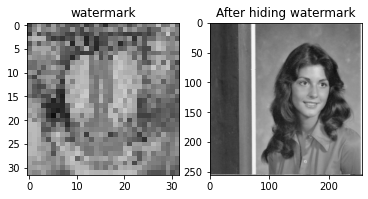

In [24]:
f,axis=plt.subplots(1,2)
uint8=np.uint8(mark_resize)
col_img=cv2.cvtColor(uint8,cv2.COLOR_BGR2RGB)
uint1=np.uint8(stego_final_result)
stego_img=cv2.cvtColor(uint1,cv2.COLOR_BGR2RGB)
axis[1].title.set_text("After hiding watermark")
axis[1].imshow(stego_img)
axis[0].title.set_text("watermark")
axis[0].imshow(col_img)

## Original image  VS Encrypted image

In [25]:
MSE=mse(img,stego_final_result)
print("MSE between original image and encrypter image : {}".format(MSE))

MSE between original image and encrypter image : 0.07183837890625


In [26]:
from skimage.metrics import structural_similarity as ssim
sim=ssim(img,stego_final_result,data_range=stego_final_result.max()-stego_final_result.min())
print("Similarity index btween original image and encrypter image : {}".format(sim))

Similarity index btween original image and encrypter image : 0.9992156396316597


In [27]:
import math
psnr=20*math.log10(255/np.sqrt(MSE))
print("PSNR btween original image and encrypter image : {}".format(psnr))

PSNR btween original image and encrypter image : 59.56723837320212


## Decryption Process

In [28]:
#inversion
# img shape 
row,col=stego_final_result.shape
# for saving result after row transformation
stego_row_mat=np.zeros((row,col),dtype=np.int32)
# for saving result after column transformation
stego_col_mat=np.zeros((row,col),dtype=np.int32)
# how far iteration will go 
end=row//2

# Iteration for a single row 
i=0
while i<row:    
    for j in range(end):
        # average formula 
        b=np.floor((int(stego_final_result[i,2*j])+int(stego_final_result[i,(2*j)+1]))/2)
        stego_row_mat[i,j]=b
        # detail formula 
        d=int(stego_final_result[i,2*j])-int(stego_final_result[i,(2*j)+1])
        stego_row_mat[i,j+int(row/2)]=d
        
    i+=1
# re-intialize for starting iteration on column
i=0
while i<row:
#     print(i)
    for j in range(end):
        # average formula used on column wise 
        b=np.floor((int(stego_row_mat[2*j,i])+int(stego_row_mat[((2*j)+1),i]))/2)
#         print(row_mat[2*j,i]+row_mat[((2*j)+1),i])
        stego_col_mat[j,i]=b
        d=int(stego_row_mat[2*j,i])-int(stego_row_mat[(2*j)+1,i])
        stego_col_mat[j+int(row/2),i]=d
    i+=1


In [29]:
# first step in inversion 
stego_row_mat

array([[ 48,  55,  54, ...,   1,   1,  15],
       [ 49,  56,  55, ...,   0,  -1,  12],
       [ 55,  62,  63, ...,  -4, -11,  14],
       ...,
       [ 73,  70,  69, ...,  -7, -60,   4],
       [ 73,  71,  69, ...,  -7, -62,   3],
       [163, 177, 186, ...,   1,   1,   6]], dtype=int32)

In [30]:
# second step in inversion
stego_col_mat

array([[  48,   55,   54, ...,    0,    0,   13],
       [  55,   62,   63, ...,   -6,  -25,   13],
       [  55,   63,   63, ...,   -8,  -42,   12],
       ...,
       [  -3,   -2,  -12, ...,    1,    1,    0],
       [  -1,   -1,    0, ...,   -3,   -1,   -1],
       [ -90, -106, -117, ...,   -8,  -63,   -3]], dtype=int32)

In [31]:
# cutting hh part form stego image
stego_hh=stego_col_mat[128:,128:]

In [32]:
# it gives all the numbers in binary
stego_binary_mat=[]
for i in range(stego_hh.shape[0]):
    for j in range(stego_hh.shape[1]):
        b=format(int(abs(stego_hh[i,j])),"08b")
        stego_binary_mat.append(b)

In [33]:
# to make a list after taking last two LSB  from binaries of matrix
s=""
lis=[]
for i in stego_binary_mat:
    if(len(lis)<(row*col)):
        lsb=i[-2:]
#         print("lsb",lsb)
        lsb1=lsb[::-1]
        if len(s)<8:
#             print(lsb1)
            s+=lsb1
        else:
            lis.append(s)
            s=""
            s+=lsb1
#             print("lsb1",s)
    else:
        continue
        
    

In [34]:
# decryption of water mark 
decrypt_img=np.zeros((mark_resize.shape),dtype=np.int32)
k=0
for i in range(decrypt_img.shape[0]):
    for j in range(decrypt_img.shape[1]):
        decrypt_img[i,j]=int(lis[k],2)
        k+=1
        

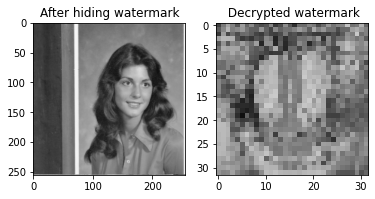

In [35]:
f,axis=plt.subplots(1,2)
uint8=np.uint8(decrypt_img)
col_img=cv2.cvtColor(uint8,cv2.COLOR_BGR2RGB)
uint1=np.uint8(stego_final_result)
stego_img=cv2.cvtColor(uint1,cv2.COLOR_BGR2RGB)
axis[0].title.set_text("After hiding watermark")
axis[0].imshow(stego_img)
axis[1].title.set_text(" Decrypted watermark")
axis[1].imshow(col_img)

### Encrypted Watermark  VS Decrypted Watermark

In [36]:
diff_mse=mse(decrypt_img,mark_resize)
print("MSE between original watermark and encrypter watermark : {}".format(diff_mse))

MSE between original watermark and encrypter watermark : 0.0


In [37]:
from skimage.metrics import structural_similarity as ssim
sim=ssim(decrypt_img,mark_resize,data_range=decrypt_img.max()-decrypt_img.min())
print("Similarity index btween original watermark and encrypter watermark : {}".format(sim))

Similarity index btween original watermark and encrypter watermark : 1.0


In [38]:
import math
psnr=20*math.log10(255/np.sqrt(diff_mse))
print("PSNR btween original watermark and encrypter watermark : {}".format(psnr))

PSNR btween original watermark and encrypter watermark : inf
